# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
import pickle as pkl
import numpy as np
from scipy.io import loadmat
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!mkdir datasets

子目錄或檔案 datasets 已經存在。


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'svhn_data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

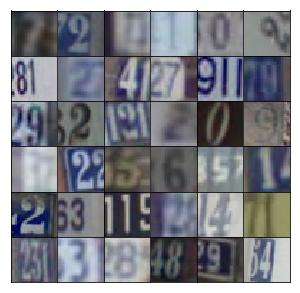

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)

for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
            
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            yield self.scaler(x), self.scaler(y)

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stack layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3.

In [9]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've build before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

In [10]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [11]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Again, nothing new here.

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [13]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, real_size[2], alpha=0.2)        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, 0.5)

Here is a function for displaying generated images.

In [14]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, sharey=True, sharex=True)
    
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img)
   
    plt.subplots_adjust(wspace=0, hspace=0)
    
    return fig, axes

And another function we can use to train our network.

In [15]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(50, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 5, 10, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very senstive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

In [16]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 3
alpha = 0.2
beta1 = 0.5

In [17]:
# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/3... Discriminator Loss: 1.5108... Generator Loss: 0.6166
Epoch 1/3... Discriminator Loss: 0.4295... Generator Loss: 2.0277
Epoch 1/3... Discriminator Loss: 0.1876... Generator Loss: 2.2523
Epoch 1/3... Discriminator Loss: 0.1540... Generator Loss: 2.6431
Epoch 1/3... Discriminator Loss: 0.1851... Generator Loss: 2.4062
Epoch 1/3... Discriminator Loss: 0.0819... Generator Loss: 3.1478
Epoch 1/3... Discriminator Loss: 0.1860... Generator Loss: 2.6563
Epoch 1/3... Discriminator Loss: 0.1238... Generator Loss: 3.2169
Epoch 1/3... Discriminator Loss: 0.1277... Generator Loss: 3.1737
Epoch 1/3... Discriminator Loss: 0.2932... Generator Loss: 2.5363


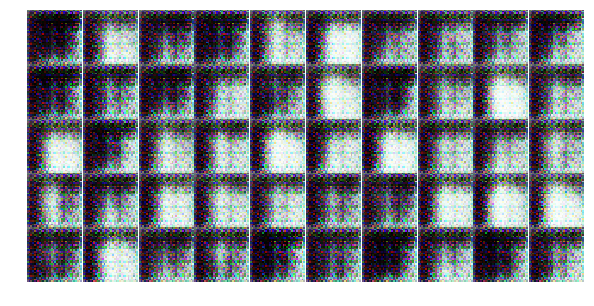

Epoch 1/3... Discriminator Loss: 0.7237... Generator Loss: 2.0853
Epoch 1/3... Discriminator Loss: 0.4762... Generator Loss: 1.6657
Epoch 1/3... Discriminator Loss: 0.6429... Generator Loss: 2.2504
Epoch 1/3... Discriminator Loss: 0.3041... Generator Loss: 2.1535
Epoch 1/3... Discriminator Loss: 0.5125... Generator Loss: 1.3487
Epoch 1/3... Discriminator Loss: 0.2048... Generator Loss: 2.4033
Epoch 1/3... Discriminator Loss: 0.1186... Generator Loss: 3.6190
Epoch 1/3... Discriminator Loss: 0.3019... Generator Loss: 1.8691
Epoch 1/3... Discriminator Loss: 0.7881... Generator Loss: 0.8834
Epoch 1/3... Discriminator Loss: 0.1517... Generator Loss: 3.6392


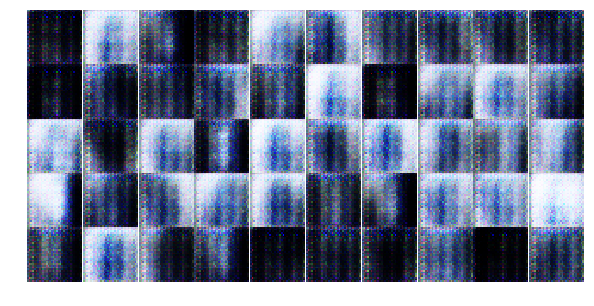

Epoch 1/3... Discriminator Loss: 1.3770... Generator Loss: 0.5314
Epoch 1/3... Discriminator Loss: 0.8169... Generator Loss: 0.9723
Epoch 1/3... Discriminator Loss: 1.1998... Generator Loss: 6.3567
Epoch 1/3... Discriminator Loss: 0.1755... Generator Loss: 3.4543
Epoch 1/3... Discriminator Loss: 0.9808... Generator Loss: 1.1920
Epoch 1/3... Discriminator Loss: 0.9314... Generator Loss: 1.3479
Epoch 1/3... Discriminator Loss: 1.2936... Generator Loss: 1.4963
Epoch 1/3... Discriminator Loss: 1.4371... Generator Loss: 0.7268
Epoch 1/3... Discriminator Loss: 0.6483... Generator Loss: 1.3306
Epoch 1/3... Discriminator Loss: 0.6311... Generator Loss: 2.1741


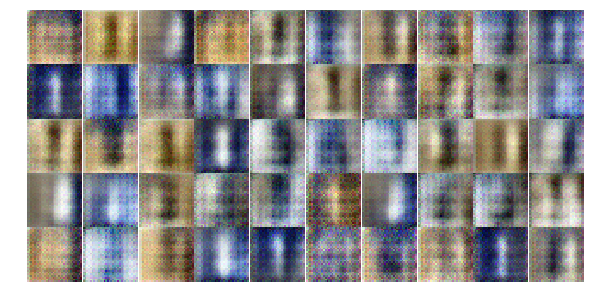

Epoch 1/3... Discriminator Loss: 1.2436... Generator Loss: 0.4402
Epoch 1/3... Discriminator Loss: 0.4004... Generator Loss: 1.7124
Epoch 1/3... Discriminator Loss: 1.0947... Generator Loss: 0.6227
Epoch 1/3... Discriminator Loss: 0.4740... Generator Loss: 1.6445
Epoch 1/3... Discriminator Loss: 0.3718... Generator Loss: 1.7220
Epoch 1/3... Discriminator Loss: 0.6306... Generator Loss: 1.1012
Epoch 1/3... Discriminator Loss: 0.9504... Generator Loss: 0.8865
Epoch 1/3... Discriminator Loss: 0.5310... Generator Loss: 2.0449
Epoch 1/3... Discriminator Loss: 0.6995... Generator Loss: 2.7250
Epoch 1/3... Discriminator Loss: 1.0046... Generator Loss: 1.2241


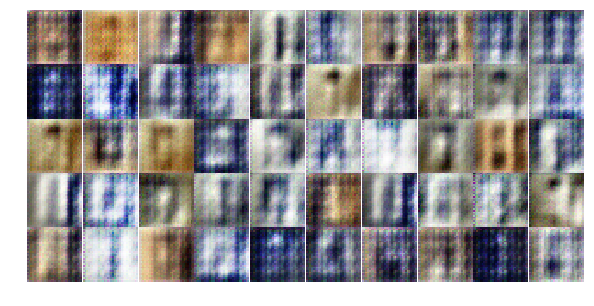

Epoch 1/3... Discriminator Loss: 0.9735... Generator Loss: 1.6954
Epoch 1/3... Discriminator Loss: 0.5717... Generator Loss: 1.9780
Epoch 1/3... Discriminator Loss: 0.6459... Generator Loss: 1.1878
Epoch 1/3... Discriminator Loss: 0.7328... Generator Loss: 1.3504
Epoch 1/3... Discriminator Loss: 0.6297... Generator Loss: 1.6784
Epoch 1/3... Discriminator Loss: 0.3950... Generator Loss: 1.7541
Epoch 1/3... Discriminator Loss: 0.2587... Generator Loss: 2.6428
Epoch 1/3... Discriminator Loss: 1.1441... Generator Loss: 1.2317
Epoch 1/3... Discriminator Loss: 1.1908... Generator Loss: 0.8151
Epoch 1/3... Discriminator Loss: 0.8095... Generator Loss: 1.6462


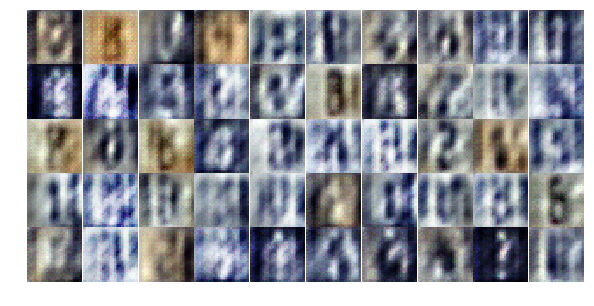

Epoch 1/3... Discriminator Loss: 0.6314... Generator Loss: 1.7113
Epoch 1/3... Discriminator Loss: 0.5953... Generator Loss: 1.6973
Epoch 1/3... Discriminator Loss: 0.8778... Generator Loss: 1.6936
Epoch 1/3... Discriminator Loss: 1.5507... Generator Loss: 0.4049
Epoch 1/3... Discriminator Loss: 0.9513... Generator Loss: 0.9504
Epoch 1/3... Discriminator Loss: 0.7509... Generator Loss: 1.1588
Epoch 1/3... Discriminator Loss: 0.6335... Generator Loss: 1.7368
Epoch 2/3... Discriminator Loss: 0.8846... Generator Loss: 1.4300
Epoch 2/3... Discriminator Loss: 0.6182... Generator Loss: 1.6831
Epoch 2/3... Discriminator Loss: 1.0234... Generator Loss: 0.7522


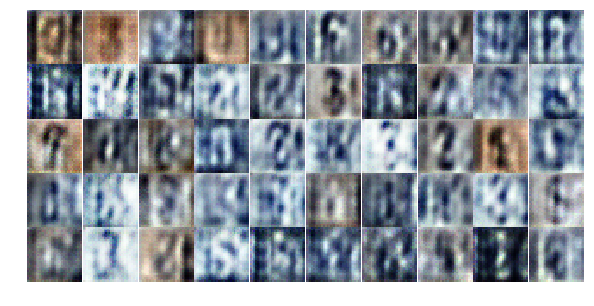

Epoch 2/3... Discriminator Loss: 0.7667... Generator Loss: 1.4623
Epoch 2/3... Discriminator Loss: 0.9890... Generator Loss: 1.0017
Epoch 2/3... Discriminator Loss: 1.2074... Generator Loss: 1.2886
Epoch 2/3... Discriminator Loss: 1.0792... Generator Loss: 1.7503
Epoch 2/3... Discriminator Loss: 0.9967... Generator Loss: 0.9632
Epoch 2/3... Discriminator Loss: 1.0227... Generator Loss: 0.9872
Epoch 2/3... Discriminator Loss: 1.0024... Generator Loss: 0.8739
Epoch 2/3... Discriminator Loss: 1.1518... Generator Loss: 1.4308
Epoch 2/3... Discriminator Loss: 0.8249... Generator Loss: 1.1025
Epoch 2/3... Discriminator Loss: 0.8647... Generator Loss: 1.0630


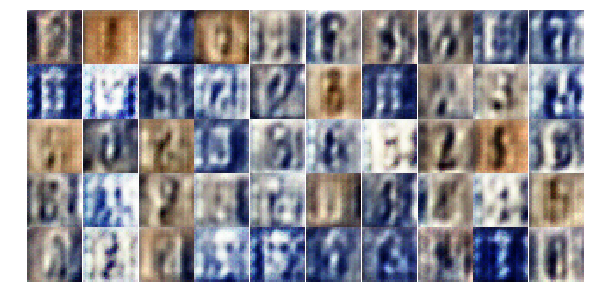

Epoch 2/3... Discriminator Loss: 0.9663... Generator Loss: 1.3569
Epoch 2/3... Discriminator Loss: 0.7997... Generator Loss: 1.4275
Epoch 2/3... Discriminator Loss: 0.8296... Generator Loss: 1.4172
Epoch 2/3... Discriminator Loss: 1.0217... Generator Loss: 0.9286
Epoch 2/3... Discriminator Loss: 1.0934... Generator Loss: 1.1749
Epoch 2/3... Discriminator Loss: 0.9799... Generator Loss: 0.8906
Epoch 2/3... Discriminator Loss: 1.0386... Generator Loss: 0.7615
Epoch 2/3... Discriminator Loss: 1.1788... Generator Loss: 0.9763
Epoch 2/3... Discriminator Loss: 0.8312... Generator Loss: 1.1409
Epoch 2/3... Discriminator Loss: 1.1506... Generator Loss: 0.6928


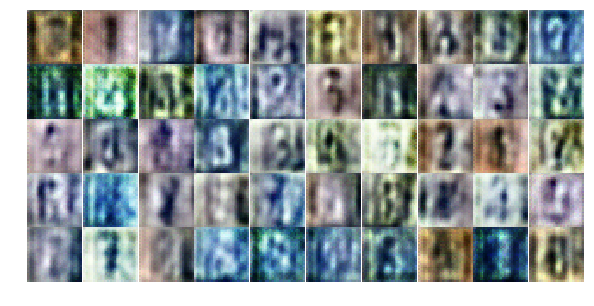

Epoch 2/3... Discriminator Loss: 0.9959... Generator Loss: 0.9892
Epoch 2/3... Discriminator Loss: 1.4540... Generator Loss: 0.4081
Epoch 2/3... Discriminator Loss: 0.7627... Generator Loss: 1.5345
Epoch 2/3... Discriminator Loss: 1.0208... Generator Loss: 1.4004
Epoch 2/3... Discriminator Loss: 1.0684... Generator Loss: 1.3043
Epoch 2/3... Discriminator Loss: 1.0937... Generator Loss: 1.2338
Epoch 2/3... Discriminator Loss: 1.1805... Generator Loss: 0.5441
Epoch 2/3... Discriminator Loss: 0.8660... Generator Loss: 0.8628
Epoch 2/3... Discriminator Loss: 1.1749... Generator Loss: 0.7387
Epoch 2/3... Discriminator Loss: 1.0518... Generator Loss: 0.8668


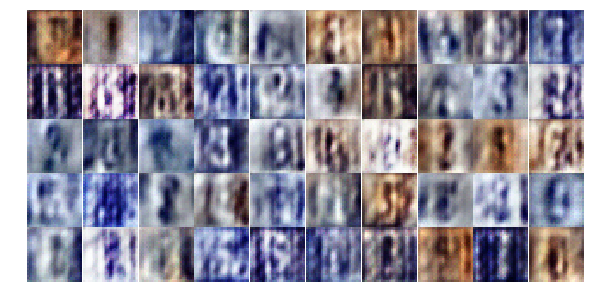

Epoch 2/3... Discriminator Loss: 1.1963... Generator Loss: 0.7196
Epoch 2/3... Discriminator Loss: 1.2775... Generator Loss: 0.6401
Epoch 2/3... Discriminator Loss: 0.9356... Generator Loss: 1.0417
Epoch 2/3... Discriminator Loss: 1.1505... Generator Loss: 0.6921
Epoch 2/3... Discriminator Loss: 0.8900... Generator Loss: 1.2811
Epoch 2/3... Discriminator Loss: 1.1409... Generator Loss: 0.7504
Epoch 2/3... Discriminator Loss: 1.2337... Generator Loss: 0.6764
Epoch 2/3... Discriminator Loss: 0.8944... Generator Loss: 1.3272
Epoch 2/3... Discriminator Loss: 0.8794... Generator Loss: 1.0149
Epoch 2/3... Discriminator Loss: 1.4354... Generator Loss: 0.4792


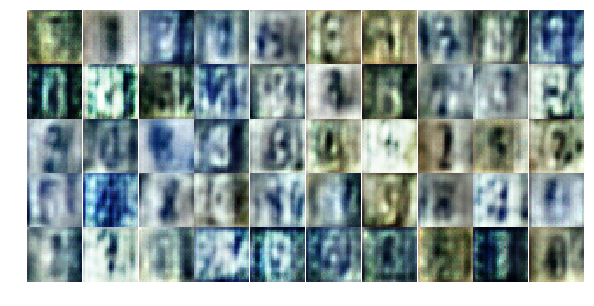

Epoch 2/3... Discriminator Loss: 1.1600... Generator Loss: 1.7368
Epoch 2/3... Discriminator Loss: 1.4883... Generator Loss: 0.9861
Epoch 2/3... Discriminator Loss: 1.1025... Generator Loss: 0.8952
Epoch 2/3... Discriminator Loss: 1.1929... Generator Loss: 0.6507
Epoch 2/3... Discriminator Loss: 0.9974... Generator Loss: 0.8520
Epoch 2/3... Discriminator Loss: 0.9808... Generator Loss: 0.7826
Epoch 2/3... Discriminator Loss: 0.7217... Generator Loss: 1.2367
Epoch 2/3... Discriminator Loss: 1.0714... Generator Loss: 1.6773
Epoch 2/3... Discriminator Loss: 0.7777... Generator Loss: 1.8507
Epoch 2/3... Discriminator Loss: 1.0131... Generator Loss: 0.9886


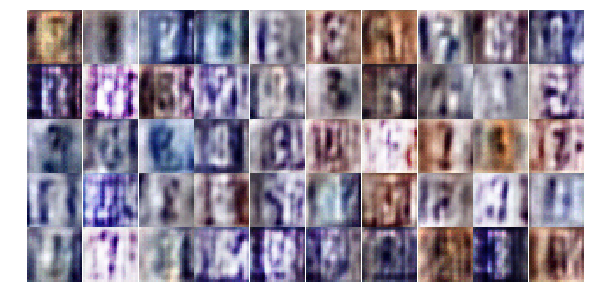

Epoch 2/3... Discriminator Loss: 1.2593... Generator Loss: 0.7713
Epoch 2/3... Discriminator Loss: 0.9303... Generator Loss: 0.8448
Epoch 2/3... Discriminator Loss: 0.9663... Generator Loss: 1.5057
Epoch 2/3... Discriminator Loss: 1.0918... Generator Loss: 0.8909
Epoch 3/3... Discriminator Loss: 0.9064... Generator Loss: 2.4939
Epoch 3/3... Discriminator Loss: 0.9297... Generator Loss: 1.0285
Epoch 3/3... Discriminator Loss: 0.6354... Generator Loss: 1.7378
Epoch 3/3... Discriminator Loss: 0.7682... Generator Loss: 1.1652
Epoch 3/3... Discriminator Loss: 0.7333... Generator Loss: 1.2551
Epoch 3/3... Discriminator Loss: 0.7117... Generator Loss: 1.2152


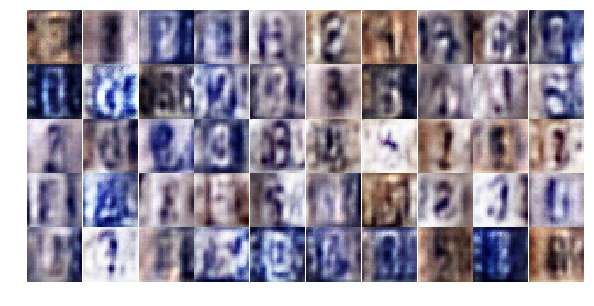

Epoch 3/3... Discriminator Loss: 0.8855... Generator Loss: 0.8381
Epoch 3/3... Discriminator Loss: 0.7519... Generator Loss: 1.1925
Epoch 3/3... Discriminator Loss: 0.6835... Generator Loss: 1.1714
Epoch 3/3... Discriminator Loss: 0.6815... Generator Loss: 1.1863
Epoch 3/3... Discriminator Loss: 0.7088... Generator Loss: 1.7041
Epoch 3/3... Discriminator Loss: 0.5585... Generator Loss: 1.6329
Epoch 3/3... Discriminator Loss: 0.6716... Generator Loss: 1.0533
Epoch 3/3... Discriminator Loss: 0.7883... Generator Loss: 0.8798
Epoch 3/3... Discriminator Loss: 0.8062... Generator Loss: 0.8145
Epoch 3/3... Discriminator Loss: 0.4893... Generator Loss: 2.0560


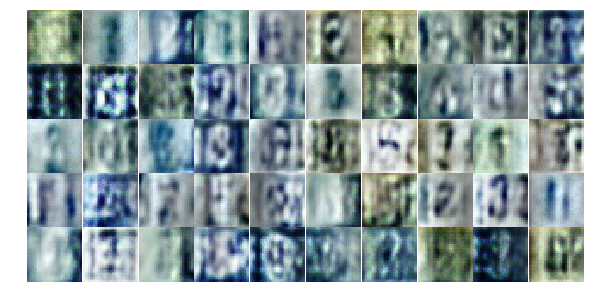

Epoch 3/3... Discriminator Loss: 0.7091... Generator Loss: 1.3862
Epoch 3/3... Discriminator Loss: 0.3424... Generator Loss: 2.1355
Epoch 3/3... Discriminator Loss: 0.2704... Generator Loss: 2.1744
Epoch 3/3... Discriminator Loss: 0.6172... Generator Loss: 1.2430
Epoch 3/3... Discriminator Loss: 0.5543... Generator Loss: 1.3237
Epoch 3/3... Discriminator Loss: 0.3968... Generator Loss: 2.6410
Epoch 3/3... Discriminator Loss: 1.2114... Generator Loss: 1.9559
Epoch 3/3... Discriminator Loss: 1.1611... Generator Loss: 0.7246
Epoch 3/3... Discriminator Loss: 0.3455... Generator Loss: 2.5209
Epoch 3/3... Discriminator Loss: 0.6408... Generator Loss: 1.1965


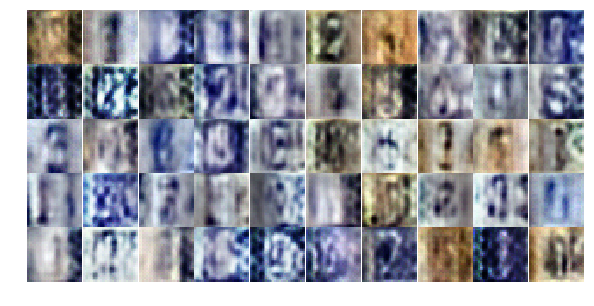

Epoch 3/3... Discriminator Loss: 0.4517... Generator Loss: 2.1917
Epoch 3/3... Discriminator Loss: 1.0179... Generator Loss: 0.8747
Epoch 3/3... Discriminator Loss: 0.8191... Generator Loss: 0.8064
Epoch 3/3... Discriminator Loss: 0.5152... Generator Loss: 1.8599
Epoch 3/3... Discriminator Loss: 0.5450... Generator Loss: 1.8797
Epoch 3/3... Discriminator Loss: 0.6856... Generator Loss: 2.0178
Epoch 3/3... Discriminator Loss: 0.8860... Generator Loss: 1.2402
Epoch 3/3... Discriminator Loss: 0.6618... Generator Loss: 1.3758
Epoch 3/3... Discriminator Loss: 0.6388... Generator Loss: 1.4684
Epoch 3/3... Discriminator Loss: 0.7507... Generator Loss: 0.8688


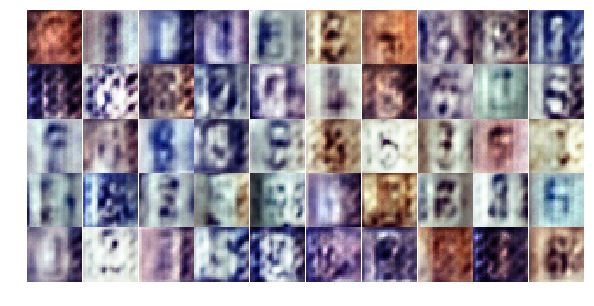

Epoch 3/3... Discriminator Loss: 0.6345... Generator Loss: 2.2332
Epoch 3/3... Discriminator Loss: 0.6558... Generator Loss: 2.4014
Epoch 3/3... Discriminator Loss: 0.4028... Generator Loss: 2.7164
Epoch 3/3... Discriminator Loss: 0.8499... Generator Loss: 0.8860
Epoch 3/3... Discriminator Loss: 0.3954... Generator Loss: 2.0179
Epoch 3/3... Discriminator Loss: 1.4146... Generator Loss: 4.4619
Epoch 3/3... Discriminator Loss: 0.3153... Generator Loss: 2.4534
Epoch 3/3... Discriminator Loss: 1.2212... Generator Loss: 1.8791
Epoch 3/3... Discriminator Loss: 0.8962... Generator Loss: 1.9850
Epoch 3/3... Discriminator Loss: 1.0809... Generator Loss: 0.8315


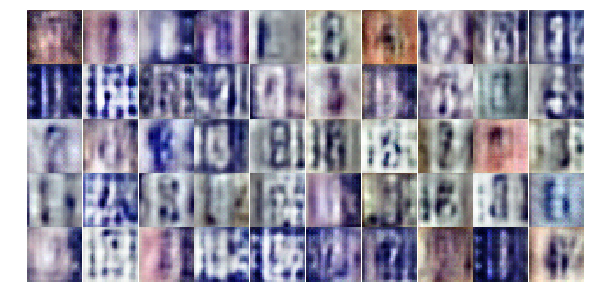

Epoch 3/3... Discriminator Loss: 1.0119... Generator Loss: 0.9259
Epoch 3/3... Discriminator Loss: 0.9271... Generator Loss: 0.8165
Epoch 3/3... Discriminator Loss: 0.6088... Generator Loss: 1.4128
Epoch 3/3... Discriminator Loss: 0.7120... Generator Loss: 1.0103
Epoch 3/3... Discriminator Loss: 1.3274... Generator Loss: 2.9247
Epoch 3/3... Discriminator Loss: 0.6316... Generator Loss: 1.4859
Epoch 3/3... Discriminator Loss: 0.4227... Generator Loss: 1.6629
Epoch 3/3... Discriminator Loss: 0.6035... Generator Loss: 2.0707
Epoch 3/3... Discriminator Loss: 0.4260... Generator Loss: 1.6680
Epoch 3/3... Discriminator Loss: 0.3137... Generator Loss: 1.9771


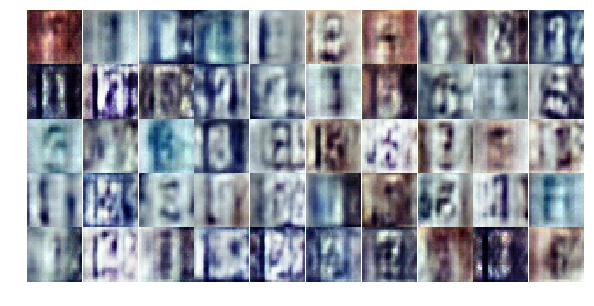

Epoch 3/3... Discriminator Loss: 1.0257... Generator Loss: 0.8489


In [18]:
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

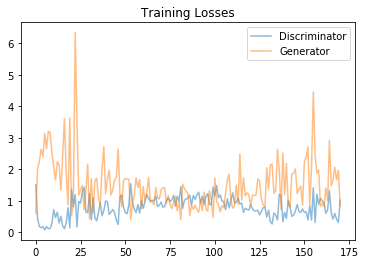

In [19]:
fig, ax = plt.subplots()
losses = np.array(losses)

plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

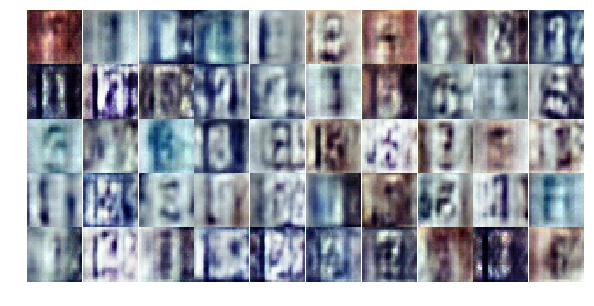

In [20]:
_ = view_samples(-1, samples, 5, 10, figsize=(10,5))